# Trabajo practico: Prediccion de lluvia Australia

Alumnos: Noir Nicolas, González Ignacio

Año: 2024

Materia: Aprendizaje automático 1

Carrera: TUIA

## introducción
En este trabajo vamos a crear un modelo de clasificación para la predicción de la lluvia al día siguiente en Australia en 10 ciudades elegidas al azar.

Para esto necesitaremos hacer ciertos análisis, escalados, imputados, etc los cuales vamos a presentar brevemente continuación (En el código va a ser explicado y justificado):

Primero necesitamos importar el dataset, como este tiene más de 10 ciudades de Australia, haremos una selección al azar con sample y reduciremos el dataset a los datos que sean de esas ciudades. El siguiente paso es dropear todos los registros que tengan un valor faltante en la variable explicativa, después chequearemos y eliminaremos filas duplicadas. Una vez hecho esta pequeña limpieza inicial dividimos el dataset en train y test siendo 80/20 la proporción, también tendremos que dividirlo de manera que en el punto donde se divida para atrás en fecha sea entrenamiento y para adelante sea prueba. A continuación analizaremos los valores faltantes de x_train, decidiendo que filas son dropeadas por la cantidad de valores faltantes. Lo siguiente es el análisis de las distribuciones, correlaciones, tipos de datos, outliers, medias, medianas, etc.
Después codificamos las variables categóricas y ciclicas,

# Librerias

In [788]:
#!pip install scikit-learn
#!pip install pandas
#!pip install matplotlib
#!pip install seaborn
#!pip install plotly

In [789]:
import pandas as pd
from sklearn.impute import KNNImputer
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.model_selection import train_test_split
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.exceptions import DataConversionWarning
from sklearn import metrics
from sklearn.exceptions import ConvergenceWarning
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, f1_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import jaccard_score
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.metrics.cluster import fowlkes_mallows_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression


# Libreria necesaria para poder ocultar errores que empeoran la visualización del notebook
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DataConversionWarning)
warnings.simplefilter(action='ignore', category=ConvergenceWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)
pd.options.mode.chained_assignment = None


## Funciones

In [790]:
def redondiar_valores(df, lista):
    for var in lista:
        if var == ['Cloud3pm'] or ['Cloud9am']:
            df[var] = df[var].round(1)
            df[var] = df[var].replace([0.9, 1.0], 0.8)
        else:
            df[var] = df[var].round().astype('bool')
    return df

variables_a_cambiar = ['Cloud9am', 'Cloud3pm', 'Location_Canberra', 'Location_Moree', 'Location_Newcastle', 'Location_Nhil', 'Location_Nuriootpa', 'Location_PearceRAAF', 'Location_Perth', 'Location_Sale', 'Location_SalmonGums']

## Contenito

In [791]:
dataset_lluvia_completo_raw = pd.read_csv('https://raw.githubusercontent.com/nacho-gonz/AA1-Archivos-2024/master/weatherAUS.csv')
ciudades_elegidas = dataset_lluvia_completo_raw["Location"].sample(10, random_state=528548).to_list()
df_ciudad = dataset_lluvia_completo_raw[dataset_lluvia_completo_raw["Location"].isin(ciudades_elegidas)]
df_ciudad.dropna(subset=['RainTomorrow'], inplace=True)

df_ciudad_ord = df_ciudad.sort_values(by='Date')

In [792]:
x_train, x_test, y_train, y_test = train_test_split(df_ciudad_ord.drop("RainTomorrow", axis=1), df_ciudad_ord['RainTomorrow'].values.reshape(-1,1), shuffle=False, test_size=0.2, random_state=28869)
#x_train, x_val, y_train, y_val = train_test_split(x_train,y_train, shuffle=False, test_size=0.1765, random_state=1765)

In [793]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((23095, 22), (5774, 22), (23095, 1), (5774, 1))

In [794]:
valores_faltantes = x_train[x_train.isna().any(axis=1)]
valores_faltantes

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday
45700,2008-02-22,Canberra,12.7,28.6,6.6,3.2,8.6,W,50.0,NaN,...,28.0,78.0,42.0,1008.3,1002.3,5.0,5.0,16.5,27.4,Yes
45705,2008-02-27,Canberra,11.7,27.6,0.0,7.8,8.1,W,48.0,NaN,...,30.0,74.0,25.0,1013.6,1009.1,2.0,6.0,17.6,26.8,No
45714,2008-03-07,Canberra,10.8,29.2,0.0,8.4,7.5,E,50.0,NaN,...,9.0,56.0,34.0,1021.6,1017.7,0.0,7.0,17.5,27.7,No
45725,2008-03-18,Canberra,12.5,29.9,0.0,5.8,10.7,NW,43.0,NaN,...,19.0,76.0,30.0,1022.7,1018.8,0.0,1.0,16.8,29.2,No
45727,2008-03-20,Canberra,11.5,29.3,0.0,5.2,8.0,NW,46.0,NaN,...,26.0,76.0,35.0,1013.8,1009.4,7.0,7.0,17.1,27.6,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117042,2015-11-17,PearceRAAF,11.5,29.0,0.0,NaN,9.0,W,70.0,WNW,...,31.0,61.0,52.0,1006.3,1008.7,3.0,8.0,25.1,25.9,No
126246,2015-11-18,SalmonGums,12.0,25.0,0.0,NaN,NaN,W,43.0,W,...,20.0,37.0,33.0,NaN,NaN,NaN,NaN,21.8,22.3,No
63605,2015-11-18,Sale,10.6,28.7,0.0,NaN,NaN,WSW,43.0,WSW,...,26.0,71.0,20.0,1013.8,1011.5,NaN,NaN,16.7,28.3,No
74394,2015-11-18,Nhil,11.8,40.1,0.0,NaN,NaN,W,63.0,N,...,22.0,28.0,11.0,1013.1,1009.3,NaN,NaN,23.6,37.2,No


In [795]:
valores_faltantes.isna().sum(axis=0)

Date                0
Location            0
MinTemp           252
MaxTemp           148
Rainfall          238
Evaporation      9876
Sunshine         8173
WindGustDir      2995
WindGustSpeed    2978
WindDir9am       2185
WindDir3pm       1070
WindSpeed9am      465
WindSpeed3pm      632
Humidity9am       255
Humidity3pm       385
Pressure9am      5028
Pressure3pm      5033
Cloud9am         5292
Cloud3pm         5882
Temp9am           173
Temp3pm           343
RainToday         238
dtype: int64

Vemos cuales son las columnas con mayor cantidad de datos faltantes (Evaporation, Sunshine, Cloud3pm, Cloud9am), y las que menos valroes faltantes tienen (Date, Location, Temp(cualquiera de sus variantes)) 

In [796]:
valores_faltantes.isna().sum(axis=1).value_counts(sort=True)

6     3321
1     2451
4     1614
2     1277
3     1077
7      813
11     315
8      293
5      183
12     177
9       39
17      37
18      28
13      28
10      15
19      10
14      10
15       4
20       4
16       1
Name: count, dtype: int64

Nuestra decision a tomar sobre los datos faltantes, es si las filas tienen mas de la mitad de sus variables como valores faltantes, la descartamos

In [797]:
x_train_compl = x_train.copy()
x_train_compl['RainTomorrow'] = y_train.flatten()
x_train_compl.dropna(thresh=12, inplace=True)

y_train_modif = x_train_compl['RainTomorrow']
x_train_modif = x_train_compl.drop(columns='RainTomorrow')
y_train_codif = pd.get_dummies(y_train_modif, drop_first=True)
y_test_codif = pd.get_dummies(y_test.flatten(), drop_first=True)

In [798]:
x_train_modif.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22796 entries, 45587 to 17530
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           22796 non-null  object 
 1   Location       22796 non-null  object 
 2   MinTemp        22698 non-null  float64
 3   MaxTemp        22710 non-null  float64
 4   Rainfall       22580 non-null  float64
 5   Evaporation    13210 non-null  float64
 6   Sunshine       14914 non-null  float64
 7   WindGustDir    20098 non-null  object 
 8   WindGustSpeed  20115 non-null  float64
 9   WindDir9am     20893 non-null  object 
 10  WindDir3pm     21977 non-null  object 
 11  WindSpeed9am   22519 non-null  float64
 12  WindSpeed3pm   22407 non-null  float64
 13  Humidity9am    22688 non-null  float64
 14  Humidity3pm    22608 non-null  float64
 15  Pressure9am    18066 non-null  float64
 16  Pressure3pm    18060 non-null  float64
 17  Cloud9am       17689 non-null  float64
 18  Cloud3p

In [799]:
#graficar_valores = x_train_compl[['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation',
#       'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
#       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
#       'Temp3pm','RainTomorrow']]
#
#fig, axes = plt.subplots(8,2)
#
#for name, ax in zip(graficar_valores, axes.flatten()):
#    sns.boxplot(x=name, data=graficar_valores, orient='h', ax=ax, hue='RainTomorrow')
#
#fig.set_size_inches(18,28)
#plt.tight_layout()
#plt.show()

In [800]:
#fig2, axes2 = plt.subplots(8,2)
#
#for name, ax in zip(graficar_valores, axes2.flatten()):
#    if name == "Rainfall":
#        sns.histplot(x=name, data=graficar_valores, ax=ax,kde=True, bins=70, hue='RainTomorrow')
#    else:
#        sns.histplot(x=name, data=graficar_valores, ax=ax,kde=True, hue='RainTomorrow')
#
#fig2.set_size_inches(18,28)
#plt.tight_layout()
#plt.show()

In [801]:
#sns.pairplot(graficar_valores, hue='RainTomorrow', corner=True)
#plt.show()

In [802]:
#vientos = ['WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainTomorrow']
#
#fig, axes = plt.subplots(2,2)
#
#for name, ax in zip(vientos, axes.flatten()):
#    sns.countplot(y=name, data=x_train_compl[vientos], orient='h', ax=ax, hue='RainTomorrow')
#    if name  == 'WindGustDir':
#        ax.title.set_text('Frecuancia de las direcicones de las rafagas de vientos')
#    if name == 'WindDir9am':
#        ax.title.set_text('Frecuancia de las direcicones del viento a las 9am')
#    if name == 'WindDir3pm':
#        ax.title.set_text('Frecuancia de las direcicones del viento a las 3am')
#    else:
#        ax.title.set_text('Frecuencia de las precipitaciones al dia siguiente')
#
#fig.set_size_inches(18,14)
#plt.tight_layout()
#plt.show()

In [803]:
x_train_compl['RainTomorrow'].value_counts()

RainTomorrow
No     18409
Yes     4387
Name: count, dtype: int64

El dataset no esta balanceado, porque en algun momento se nos va a pedir que se tome una decision en base al balanceo del dataset, siendo undersampling u oversampling en sus diferentes formas o methodos.

---

In [804]:
puntos_8 = {'NNE': 'NE', 'ENE': 'E', 'ESE': 'SE', 'SSE':'S', 'SSW': 'SW', 'WSW': 'W', 'WNW': 'NW', 'NNW': 'N'}

x_train_modif['WindGustDir'] = x_train_modif['WindGustDir'].replace(puntos_8)
x_train_modif['WindDir9am'] = x_train_modif['WindDir9am'].replace(puntos_8)
x_train_modif['WindDir3pm'] = x_train_modif['WindDir3pm'].replace(puntos_8)

x_test['WindGustDir'] = x_test['WindGustDir'].replace(puntos_8)
x_test['WindDir9am'] = x_test['WindDir9am'].replace(puntos_8)
x_test['WindDir3pm'] = x_test['WindDir3pm'].replace(puntos_8)

In [805]:
x_train_modif['Date'] = pd.to_datetime(x_train_modif['Date'])
x_train_modif['week_year'] = x_train_modif['Date'].dt.strftime('%U')

x_test['Date'] = pd.to_datetime(x_test['Date'])
x_test['week_year'] = x_test['Date'].dt.strftime('%U')

enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1).set_output(transform='pandas')

enc.fit(x_train_modif[['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm']])


x_train_modif[['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm']] = enc.transform(x_train_modif[['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm']])

x_test[['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm']] = enc.transform(x_test[['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm']])

x_train_modif['week_year'] = x_train_modif['week_year'].astype(int)


x_train_modif.drop('Date', axis=1, inplace=True)
x_test.drop('Date', axis=1, inplace=True)

In [806]:
x_train_codif = pd.get_dummies(data=x_train_modif ,columns=["RainToday"], drop_first=True)
x_test_codif = pd.get_dummies(data=x_test, columns=["RainToday"], drop_first=True)

In [807]:
reg = LinearRegression()

imp_mean = IterativeImputer(estimator=reg, initial_strategy='median',imputation_order='roman' ,random_state=120931).set_output(transform='pandas')
x_train_imputer = imp_mean.fit_transform(x_train_codif)
x_test_imputer = imp_mean.transform(x_test_codif)


In [808]:
x_train_imputer.describe()

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,week_year,RainToday_Yes
count,22796.000000,22796.000000,22796.000000,22796.000000,22796.000000,22796.000000,22796.000000,22796.000000,22796.000000,22796.000000,...,22796.000000,22796.000000,22796.000000,22796.000000,22796.000000,22796.000000,22796.000000,22796.000000,22796.000000,22796.000000
mean,4.458019,10.997572,23.639692,1.854472,5.226209,8.056073,3.652836,37.732715,3.304325,3.840036,...,67.427754,46.880365,1018.465296,1015.907160,3.922540,4.099307,16.712329,22.136415,26.140990,0.190647
std,2.999575,6.133520,6.743525,6.819803,3.489808,3.513356,2.347875,13.067036,2.235971,2.328311,...,18.311213,19.364230,6.213960,6.000356,2.743880,2.464240,6.116394,6.575731,14.758331,0.392820
min,0.000000,-8.000000,4.100000,-1.408696,-2.113638,-0.452351,0.000000,9.000000,-0.383668,0.000000,...,3.000000,1.000000,987.400000,985.500000,-2.633143,0.000000,-1.300000,3.700000,0.000000,0.000000
25%,2.000000,6.600000,18.600000,0.000000,2.748859,5.616879,2.000000,28.000000,1.901752,2.000000,...,55.000000,32.000000,1014.800000,1012.400000,1.000000,2.000000,12.300000,17.200000,13.000000,0.000000
50%,5.000000,11.000000,23.200000,0.000000,4.697944,8.700000,4.000000,37.000000,3.000000,4.000000,...,68.000000,46.000000,1018.500000,1015.900000,4.000000,4.000000,16.500000,21.700000,26.000000,0.000000
75%,7.000000,15.500000,28.400000,0.400000,7.200000,10.741994,6.000000,44.000000,5.000000,6.000000,...,81.000000,59.000000,1022.190611,1019.355715,7.000000,6.000000,21.200000,26.800000,39.000000,0.000000
max,9.000000,31.200000,47.300000,240.000000,60.800000,17.774694,7.459615,123.108588,7.000000,7.000000,...,107.466448,100.000000,1040.600000,1037.900000,9.605591,10.267751,40.200000,45.800000,52.000000,1.000000


In [809]:
def positivisar(df):

    variables = [ 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Cloud9am', 'Cloud3pm']

    columnas = df.columns
    for col in columnas:
        if col in ['MinTemp','MaxTemp','Temp9am','Temp3pm']:
            continue
        df[col][df[col] < 0] = 0
        df[col] = df[col].round(1)
        if col in variables:
            df[col] = df[col].astype(int)
        if col in ['Cloud9am', 'Cloud3pm']:
            df[col] = df[col].replace([9, 10], 8) 
    return df

In [810]:
x_train_imputer_pos = positivisar(x_train_imputer)
x_test_imputer_pos = positivisar(x_test_imputer)

In [811]:
x_train_imputer_pos.describe()

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,week_year,RainToday_Yes
count,22796.000000,22796.000000,22796.000000,22796.000000,22796.000000,22796.000000,22796.000000,22796.000000,22796.000000,22796.000000,...,22796.000000,22796.000000,22796.000000,22796.000000,22796.000000,22796.000000,22796.000000,22796.000000,22796.000000,22796.000000
mean,4.458019,10.997572,23.639692,1.855940,5.230931,8.056054,3.600456,37.679725,3.268029,3.823960,...,67.425601,46.876864,1018.465187,1015.907238,3.831769,3.986840,16.712329,22.136415,26.140990,0.190647
std,2.999575,6.133520,6.743525,6.819324,3.482624,3.513343,2.355310,13.095335,2.235296,2.333337,...,18.310472,19.363789,6.213953,6.000385,2.759226,2.492472,6.116394,6.575731,14.758331,0.392820
min,0.000000,-8.000000,4.100000,0.000000,0.000000,0.000000,0.000000,9.000000,0.000000,0.000000,...,3.000000,1.000000,987.400000,985.500000,0.000000,0.000000,-1.300000,3.700000,0.000000,0.000000
25%,2.000000,6.600000,18.600000,0.000000,2.700000,5.600000,2.000000,28.000000,1.000000,2.000000,...,55.000000,32.000000,1014.800000,1012.400000,1.000000,2.000000,12.300000,17.200000,13.000000,0.000000
50%,5.000000,11.000000,23.200000,0.000000,4.700000,8.700000,4.000000,37.000000,3.000000,4.000000,...,68.000000,46.000000,1018.500000,1015.900000,4.000000,4.000000,16.500000,21.700000,26.000000,0.000000
75%,7.000000,15.500000,28.400000,0.400000,7.200000,10.700000,6.000000,44.000000,5.000000,6.000000,...,81.000000,59.000000,1022.200000,1019.400000,7.000000,6.000000,21.200000,26.800000,39.000000,0.000000
max,9.000000,31.200000,47.300000,240.000000,60.800000,17.800000,7.000000,123.000000,7.000000,7.000000,...,107.000000,100.000000,1040.600000,1037.900000,8.000000,8.000000,40.200000,45.800000,52.000000,1.000000


# Descodificacion de variables

In [812]:
x_train_imputer_decodif = enc.inverse_transform(x_train_imputer_pos[['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm']])
x_test_imputer_decodif = enc.inverse_transform(x_test_imputer_pos[['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm']])

In [813]:
x_train_index = x_train_imputer_pos.reset_index().drop('index', axis=1)
x_train_vacio = x_train_index.drop(['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm'], axis=1)
x_train_decodif = pd.DataFrame(data=x_train_imputer_decodif, columns= ['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm'])
x_train_merge_imp = pd.merge(x_train_vacio, x_train_decodif,left_index=True, right_index=True, how='left')

x_test_index = x_test_imputer_pos.reset_index().drop('index', axis=1)
x_test_vacio = x_test_index.drop(['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm'], axis=1)
x_test_decodif = pd.DataFrame(data=x_test_imputer_decodif, columns= ['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm'])
x_test_merge_imp = pd.merge(x_test_vacio, x_test_decodif,left_index=True, right_index=True, how='left')

In [814]:
def codificar_variables(dataset):
    """
    Codifica y reemplaza date, WindGustDir, WindDir9am, WindDir3pm, Raintoday, Location
    """
    
    dataset['sin_week'] = np.sin(2 * np.pi * dataset['week_year'] / 52)
    dataset['cos_week'] = np.cos(2 * np.pi * dataset['week_year'] / 52)
    dataset.drop('week_year', axis=1, inplace=True)

    puntos_cardinales = ['N', 'NE', 'E', 'SE', 'S', 'SW', 'W','NW']

    angulos = np.arange(0, 360, 45)
    df_angulos_cardinal = pd.DataFrame({'puntos': puntos_cardinales, 'angulos': angulos})
    
    dataset_ang = dataset.merge(df_angulos_cardinal, left_on='WindGustDir', right_on=['puntos'], how='left')
    dataset_ang = dataset.merge(df_angulos_cardinal, left_on='WindDir9am', right_on=['puntos'], how='left')
    dataset_ang = dataset.merge(df_angulos_cardinal, left_on='WindDir3pm', right_on=['puntos'], how='left')

    dataset_ang['sin_WindGustDir'] = round(np.sin(2 * np.pi * dataset_ang['angulos'] / 360), ndigits=4)
    dataset_ang['cos_WindGustDir'] = round(np.cos(2 * np.pi * dataset_ang['angulos'] / 360), ndigits=4)

    dataset_ang['sin_WindDir9am'] = round(np.sin(2 * np.pi * dataset_ang['angulos'] / 360), ndigits=4)
    dataset_ang['cos_WindDir9am'] = round(np.cos(2 * np.pi * dataset_ang['angulos'] / 360), ndigits=4)

    dataset_ang['sin_WindDir3pm'] = round(np.sin(2 * np.pi * dataset_ang['angulos'] / 360), ndigits=4)
    dataset_ang['cos_WindDir3pm'] = round(np.cos(2 * np.pi * dataset_ang['angulos'] / 360), ndigits=4)

        
    dataset_ang.drop('WindGustDir', axis=1, inplace=True)
    dataset_ang.drop('WindDir9am', axis=1, inplace=True)
    dataset_ang.drop('WindDir3pm', axis=1, inplace=True)

    dataset_ang.drop('angulos', axis=1, inplace=True)
    dataset_ang.drop('puntos', axis=1, inplace=True)
    
    dataset_codificado = pd.get_dummies(dataset_ang, columns=['Location'], drop_first=True)
    return dataset_codificado

In [815]:
x_train_procesado = codificar_variables(x_train_merge_imp)
x_test_procesado = codificar_variables(x_test_merge_imp)

In [816]:
df_train_completo = x_train_procesado.copy()
df_train_completo['RainTomorrow'] = y_train_codif

In [817]:
#matriz_completa = df_train_completo.corr()
#
#fig, ax = plt.subplots(figsize=(40,40))
#sns.heatmap(matriz_completa, annot=True, vmax=1, vmin=-1, cmap='vlag')
#plt.show()

preguntar si el heatmap es encesario con todas las variables

esta balanceado el dataset!?

## 2

In [818]:
modelo_relog =LogisticRegression(class_weight='balanced',random_state=25923)
modelo_relog.fit(x_train_procesado, y_train_codif)
y_probs_relog = modelo_relog.predict_proba(x_test_procesado)[:, 1]

y_pred_relog = modelo_relog.predict(x_test_procesado)


modelo_relog_desba = LogisticRegression(random_state=25923)
modelo_relog_desba.fit(x_train_procesado, y_train_codif)
y_probs_relog_desba = modelo_relog_desba.predict_proba(x_test_procesado)[:, 1]

y_pred_relog_desba = modelo_relog_desba.predict(x_test_procesado)

In [842]:
# Crear las métricas para el modelo balanceado (Llueve y No Llueve)
metrics_balanceado_llueve = {
    'Accuracy': accuracy_score(y_test_codif, y_pred_relog),
    'Precision': precision_score(y_test_codif, y_pred_relog, pos_label=1),
    'Recall': recall_score(y_test_codif, y_pred_relog, pos_label=1),
    'F1': f1_score(y_test_codif, y_pred_relog, pos_label=1),
    'Matthews': matthews_corrcoef(y_test_codif, y_pred_relog),
    'Jaccard': jaccard_score(y_test_codif, y_pred_relog)
}

metrics_balanceado_no_llueve = {
    'Accuracy': accuracy_score(y_test_codif, y_pred_relog),
    'Precision': precision_score(y_test_codif, y_pred_relog, pos_label=0),
    'Recall': recall_score(y_test_codif, y_pred_relog, pos_label=0),
    'F1': f1_score(y_test_codif, y_pred_relog, pos_label=0),
    'Matthews': matthews_corrcoef(y_test_codif, y_pred_relog),
    'Jaccard': jaccard_score(y_test_codif, y_pred_relog)
}

# Crear las métricas para el modelo desbalanceado (Llueve y No Llueve)
metrics_desbalanceado_llueve = {
    'Accuracy': accuracy_score(y_test_codif, y_pred_relog_desba),
    'Precision': precision_score(y_test_codif, y_pred_relog_desba, pos_label=1),
    'Recall': recall_score(y_test_codif, y_pred_relog_desba, pos_label=1),
    'F1': f1_score(y_test_codif, y_pred_relog_desba, pos_label=1),
    'Matthews': matthews_corrcoef(y_test_codif, y_pred_relog_desba),
    'Jaccard': jaccard_score(y_test_codif, y_pred_relog_desba)
}

metrics_desbalanceado_no_llueve = {
    'Accuracy': accuracy_score(y_test_codif, y_pred_relog_desba),
    'Precision': precision_score(y_test_codif, y_pred_relog_desba, pos_label=0),
    'Recall': recall_score(y_test_codif, y_pred_relog_desba, pos_label=0),
    'F1': f1_score(y_test_codif, y_pred_relog_desba, pos_label=0),
    'Matthews': matthews_corrcoef(y_test_codif, y_pred_relog_desba),
    'Jaccard': jaccard_score(y_test_codif, y_pred_relog_desba)
}

# Crear el DataFrame con las métricas para ambas clases y ambos modelos
metricas_relog = pd.DataFrame({
    'Accuracy': [
        metrics_balanceado_llueve['Accuracy'], metrics_balanceado_no_llueve['Accuracy'], 
        metrics_desbalanceado_llueve['Accuracy'], metrics_desbalanceado_no_llueve['Accuracy']
    ],
    'Precision': [
        metrics_desbalanceado_llueve['Precision'], metrics_desbalanceado_no_llueve['Precision'], 
        metrics_balanceado_llueve['Precision'], metrics_balanceado_no_llueve['Precision']
    ],
    'Recall': [
        metrics_balanceado_llueve['Recall'], metrics_balanceado_no_llueve['Recall'], 
        metrics_desbalanceado_llueve['Recall'], metrics_desbalanceado_no_llueve['Recall']
    ],
    'F1': [
        metrics_balanceado_llueve['F1'], metrics_balanceado_no_llueve['F1'], 
        metrics_desbalanceado_llueve['F1'], metrics_desbalanceado_no_llueve['F1']
    ],
    'Matthews': [
        metrics_balanceado_llueve['Matthews'], metrics_balanceado_no_llueve['Matthews'], 
        metrics_desbalanceado_llueve['Matthews'], metrics_desbalanceado_no_llueve['Matthews']
    ],
    'Jaccard': [
        metrics_balanceado_llueve['Jaccard'], metrics_balanceado_no_llueve['Jaccard'], 
        metrics_desbalanceado_llueve['Jaccard'], metrics_desbalanceado_no_llueve['Jaccard']
    ]
}, index=['Balanceado - Llueve', 'Balanceado - No Llueve', 'Desbalanceado - Llueve', 'Desbalanceado - No Llueve'])


metricas_relog


,Accuracy,Precision,Recall,F1,Matthews,Jaccard
Balanceado - Llueve,0.786283,0.737481,0.746824,0.571528,0.461737,0.400097
Balanceado - No Llueve,0.786283,0.879570,0.795591,0.857637,0.461737,0.400097
Desbalanceado - Llueve,0.863353,0.462880,0.441016,0.551959,0.499280,0.381176
Desbalanceado - No Llueve,0.863353,0.930180,0.962971,0.919383,0.499280,0.381176


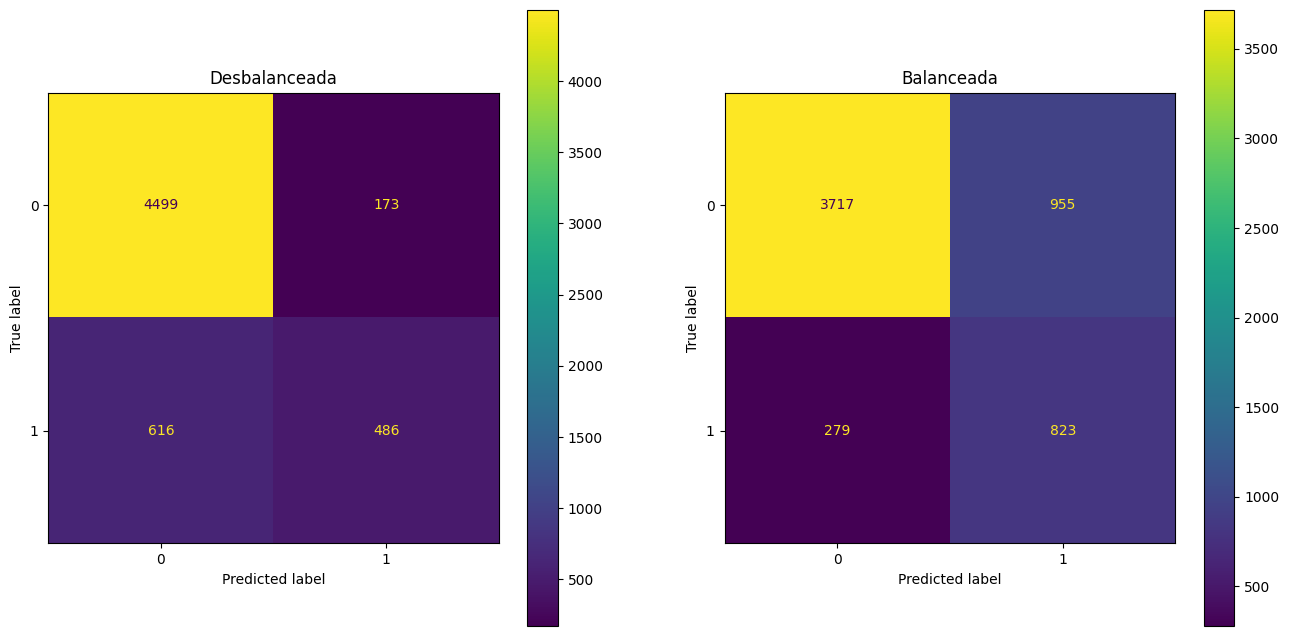

In [841]:
confusion_matrix_relog = confusion_matrix(y_test_codif, y_pred_relog)
confusion_matrix_relog_desba = confusion_matrix(y_test_codif, y_pred_relog_desba)


fig_matrix, axes_matrix = plt.subplots(1,2, figsize = (16, 8))

metrics.ConfusionMatrixDisplay(confusion_matrix= confusion_matrix_relog).plot(ax=axes_matrix[1])
axes_matrix[1].title.set_text('Balanceada')

metrics.ConfusionMatrixDisplay(confusion_matrix= confusion_matrix_relog_desba).plot(ax=axes_matrix[0])
axes_matrix[0].title.set_text('Desbalanceada')

plt.show()

vemos que tenemos mas falsos negativos que falsos positivos, esto puede darse porque el dataset esta desbalanceado, teniendo pocos casos de lluvia.

Los falsos negativos quieren decir que el modelo predice que no iba a llover y llueve
Los falsos positivos quieren decir que el modelo pecide que va a llover y no llueve 

ROC

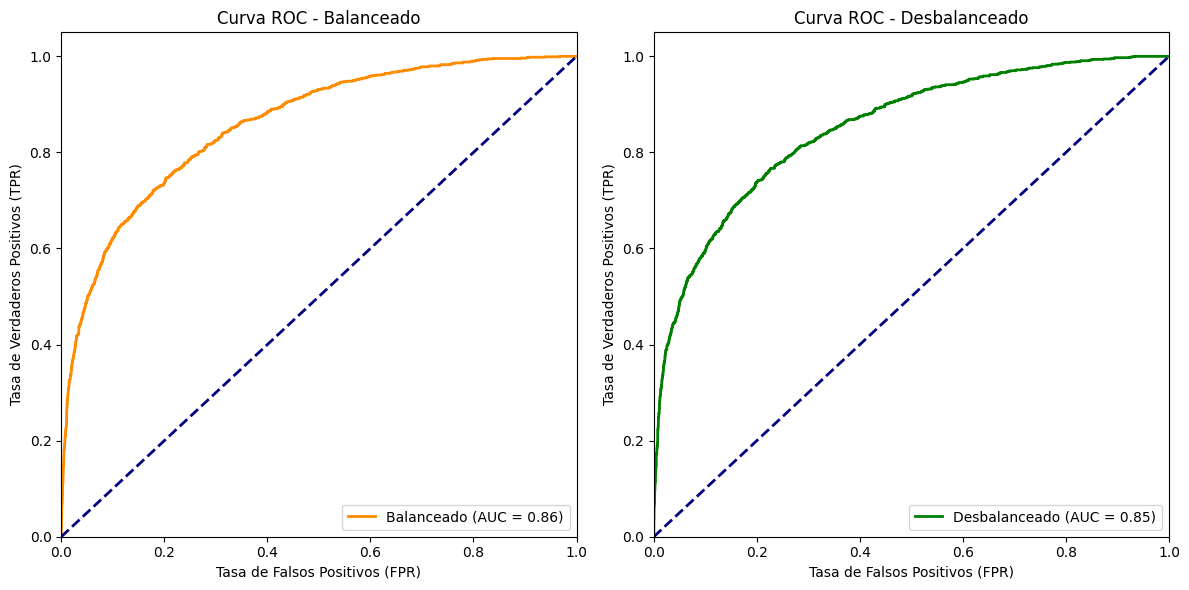

In [844]:
fpr_relog, tpr_relog, thresholds_relog = roc_curve(y_test_codif, y_probs_relog)
roc_auc_relog = auc(fpr_relog, tpr_relog)

# Curva ROC para el modelo desbalanceado
fpr_relog_desba, tpr_relog_desba, thresholds_relog_desba = roc_curve(y_test_codif, y_probs_relog_desba)
roc_auc_relog_desba = auc(fpr_relog_desba, tpr_relog_desba)

# Crear la figura con 2 subplots (1 fila, 2 columnas)
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Gráfico para el modelo balanceado
axes[0].plot(fpr_relog, tpr_relog, color='darkorange', lw=2, label='Balanceado (AUC = %0.2f)' % roc_auc_relog)
axes[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[0].set_xlim([0.0, 1.0])
axes[0].set_ylim([0.0, 1.05])
axes[0].set_xlabel('Tasa de Falsos Positivos (FPR)')
axes[0].set_ylabel('Tasa de Verdaderos Positivos (TPR)')
axes[0].set_title('Curva ROC - Balanceado')
axes[0].legend(loc="lower right")

# Gráfico para el modelo desbalanceado
axes[1].plot(fpr_relog_desba, tpr_relog_desba, color='green', lw=2, label='Desbalanceado (AUC = %0.2f)' % roc_auc_relog_desba)
axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('Tasa de Falsos Positivos (FPR)')
axes[1].set_ylabel('Tasa de Verdaderos Positivos (TPR)')
axes[1].set_title('Curva ROC - Desbalanceado')
axes[1].legend(loc="lower right")

# Ajustar el espacio entre gráficos
plt.tight_layout()
plt.show()

Parece un buen fitting (*^_^*)

Modelo base


In [826]:
from sklearn.dummy import DummyClassifier

dummy_clasif = DummyClassifier(strategy='stratified', random_state=12349)
dummy_clasif.fit(x_train_procesado, y_train_codif)

y_probs_dummy = dummy_clasif.predict_proba(x_train_procesado)[:, 1]


y_pred_dummy_clasif = dummy_clasif.predict(x_test_procesado)

presicion_dummy = precision_score(y_test_codif ,y_pred_dummy_clasif)
accuracy_dummy = accuracy_score(y_test_codif, y_pred_dummy_clasif)
recall_dummy = recall_score(y_test_codif, y_pred_dummy_clasif, average='weighted')
f1_dummy = f1_score(y_test_codif, y_pred_dummy_clasif, average='weighted')
matthews_dummy = matthews_corrcoef(y_test_codif, y_pred_dummy_clasif)
jaccard_dummy = jaccard_score(y_test_codif, y_pred_dummy_clasif)

metricas_dummy = pd.DataFrame({'Precision': [presicion_dummy], 'Accuracy': [accuracy_dummy], 'Recall': [recall_dummy], 'F1': [f1_dummy], 'matthews':[matthews_dummy], 'jaccard':[jaccard_dummy]})
metricas_dummy

,Precision,Accuracy,Recall,F1,matthews,jaccard
0,0.19891,0.694319,0.694319,0.694266,0.009949,0.110383


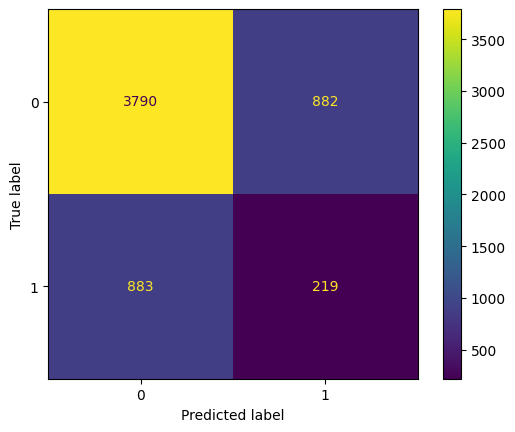

In [827]:
confusion_matrix_dummy = confusion_matrix(y_test_codif, y_pred_dummy_clasif)
metrics.ConfusionMatrixDisplay(confusion_matrix= confusion_matrix_dummy).plot()
plt.show()

In [828]:
fpr_dummy,tpr_dummy,tresholds_dummy = roc_curve(y_train_codif, y_probs_dummy)
roc_auc_dummy = auc(fpr_dummy, tpr_dummy)

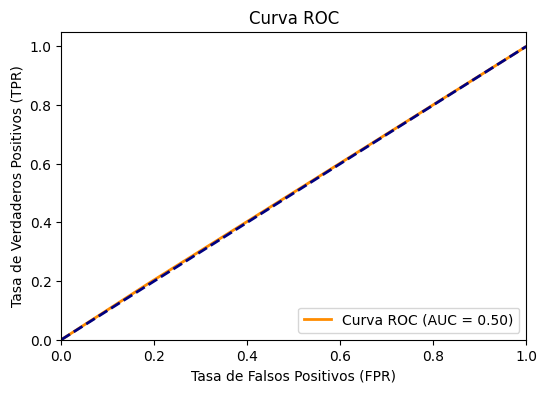

In [829]:
plt.figure(figsize=(6, 4))
plt.plot(fpr_dummy, tpr_dummy, color='darkorange', lw=2, label='Curva ROC (AUC = %0.2f)' % roc_auc_dummy)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

Se puede hacer la moda xq es corki corki